In [1]:
import os
import gnssrefl.gps as g
import gnssrefl.rinex2snr as rnx
import gnssrefl.quickLook_function as quick
import gnssrefl.gnssir as guts
import json
import pandas as pd 
import numpy as np
import check_parameters
import requests
import matplotlib.pyplot as plt

from csv import reader
import re
from datetime import datetime
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns; sns.set_theme(style="whitegrid");

# making sure that env variables are set - if they are then nothing will print to screen
g.check_environ_variables()

%matplotlib inline

ModuleNotFoundError: No module named 'check_parameters'

### Dye2, Greenland 

**Station Name:** gls1

**Location:**  Dye2, Qeqqata Province, Greenland 

**Archive:**  [UNAVCO](http://www.unavco.org), [SOPAC](http://sopac-csrc.ucsd.edu/index.php/sopac/)

**DOI:**  [https://doi.org/10.7283/T5WS8RDB](https://doi.org/10.7283/T5WS8RDB)

**Ellipsoidal Coordinates:**

- Latitude: 66.47940

- Longitude:  -46.31015

- Height: 2150 m

[Station Page at UNAVCO](https://www.unavco.org/instrumentation/networks/status/nota/overview/gls1)

[Station Page at Nevada Geodetic Laboratory](http://geodesy.unr.edu/NGLStationPages/stations/GLS1.sta)

[Google Maps Link](https://goo.gl/maps/391a7h2HpacAa59u8) 

<img src="gls1-photo.png" width="400">
<img src="gls1.jpg" width="400">
<BR>


## Data Summary

Station gls1 was installed at [Dye2](http://greenlandtoday.com/dye-2-a-relic-from-a-not-so-distant-past/?lang=en) on the Greenland Ice Sheet in 2011. 
The antenna is mounted on a long pole; approximately 3.5-meter of the pole was above the ice at the time of installation. 
The receiver at the site only consistently tracks legacy GPS signals. A detailed discussion of the monument and 
data from the station can be found in [Larson, MacFerrin, and Nylen (2020)](https://tc.copernicus.org/articles/14/1985/2020/tc-14-1985-2020.pdf). 
The latest position time series for gls1 can be retrieved 
from the [Nevada Geodetic Laboratory](http://geodesy.unr.edu/gps_timeseries/tenv3/IGS14/GLS1.tenv3). 
We also have a utility you can use: **download_unr**

As gls1 is on an ice sheet and the ice surface is relatively smooth in all directions, it 
is unlikely that a complicated azimuth mask will be required.
gls1 was originally installed with an elevation mask of 7 degrees, which is suboptimal for reflections research.
Even though the mask was later removed, we will use 7 degrees as the minimum elevation angle for all our analysis.
Similarly, even though the site managers later changed to enable L2C tracking, to ensure that 
a consistent dataset is being used, we will only use L1 data. gls1 is an example case 
for the GNSS-IR Web App:

In [3]:
%%html
<iframe src="https://gnss-reflections.org/api?example=gls1" width="800" height="950"></iframe>

## quickLook 

Our ultimate goal in this use case is to analyze one year of data. We have chosen the year 
2012 because there was a large melt event on the ice sheet. In order to set the proper
quality control parameters, we will use **quickLook** for one day. First we need to translate 
one day of RINEX data using **rinex2snr**. We will use day of year 100:

In [14]:
station = 'gls1'
year = 2012 
doy = 100

lat = 66.4794
long = -46.3102
height = 2148.578

In [10]:
# To understand what rinex2snr returns, you can uncomment the next line of code to learn more about this function 
# and it's default parameters
# check_parameters.rinex2snr?
args = check_parameters.rinex2snr(station, year, doy, translator='fortran')
rnx.run_rinex2snr(**args)

Will seek RINEX file  gls1  year: 2012  doy: 100  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls11000.12.snr66


In [11]:
# making a plotting function for the quicklook function
def quicklook_results(args, values):
    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,10))
    quadrants = ['NW', 'NE', 'SW', 'SE']
    axes = [ax[0,0], ax[0,1], ax[1,0], ax[1,1]]

    for i, quadrant in enumerate(quadrants):
        satellites = values[quadrant].keys()
        fail_satellites = values[f'f{quadrant}'].keys()

        for failsat in fail_satellites:
            axes[i].plot(values[f'f{quadrant}'][failsat][0], values[f'f{quadrant}'][failsat][1], color='lightgrey') 
        for sat in satellites:
            axes[i].plot(values[quadrant][sat][0], values[quadrant][sat][1])

    ax[0,0].set_title('Northwest', size=14)
    ax[0,1].set_title('Northeast',size=14)
    ax[1,0].set_title('Southwest', size=14)
    ax[1,1].set_title('Southeast', size=14)

    for ax in axes:
        ax.set_xlabel('reflector height (m)', size=14)
        ax.set_ylabel('volts/volts', size=14)
        ax.grid()
    
    fig.suptitle(f'GNSS Station {args["station"].upper()}, {args["year"]} doy {args["doy"]}, freq L1, elevation angles {args["e1"]}-{args["e2"]} \n', size=16)
    fig.tight_layout()
    plt.show()
    
    
def quicklook_metrics(args, values):
#     fig, ax = plt.subplots(ncols=1, nrows=3, figsize=(10,10), sharex=True)
    quadrants = ['NW', 'NE', 'SW', 'SE']
    
    # re-organizing the data in a plotting friendly format
    success_data = {'Azimuth': [], 'Reflector Height': [], 'Peak to Noise':[], 'Amplitude': []}
    fail_data =  {'Azimuth': [], 'Reflector Height': [], 'Peak to Noise': [], 'Amplitude': []}
    
    for i, quadrant in enumerate(quadrants):
        for j in values[quadrant].keys():
            success_data['Azimuth'].append(datakeys[quadrant][j][0])
            success_data['Reflector Height'].append(datakeys[quadrant][j][1])
            success_data['Peak to Noise'].append(datakeys[quadrant][j][5])
            success_data['Amplitude'].append(datakeys[quadrant][j][4])
        for k in values[f'f{quadrant}'].keys():
            fail_data['Azimuth'].append(datakeys[f'f{quadrant}'][k][0])
            fail_data['Reflector Height'].append(datakeys[f'f{quadrant}'][k][1])
            fail_data['Peak to Noise'].append(datakeys[f'f{quadrant}'][k][5])
            fail_data['Amplitude'].append(datakeys[f'f{quadrant}'][k][4])

    return pd.DataFrame(success_data), pd.DataFrame(fail_data)   

minimum elevation angle (degrees) for this dataset:  6.8543
It looks like the receiver had an elevation mask


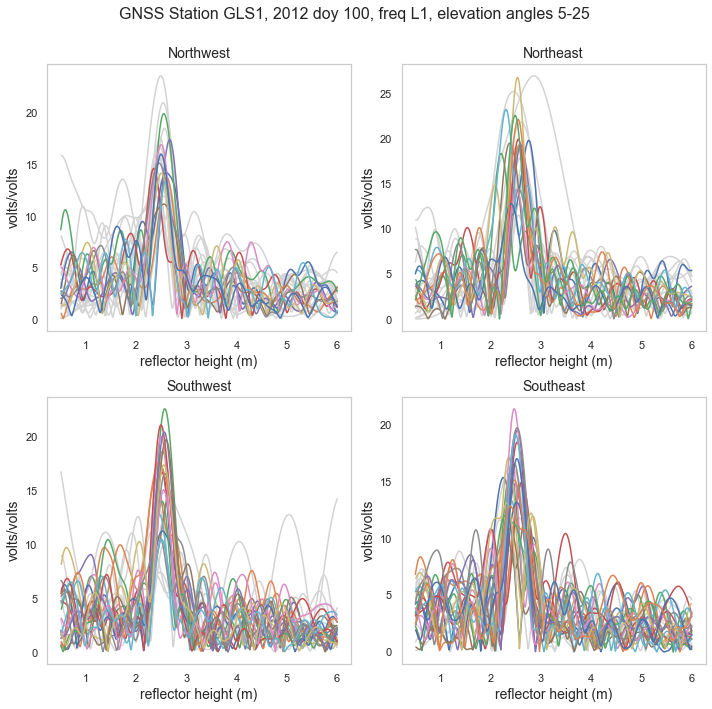

In [12]:
args = check_parameters.quicklook(station, year, doy=doy)
values, datakeys = quick.quickLook_function(**args)
quicklook_results(args, values)

This is a geographically oriented-summary of the frequency content of the GPS data.
The peaks in these periodograms tell us how high the GPS antenna is above the ice surface.
The peaks are associated with a reflector height (RH) of ~2.5 meters.

The next plot shows results with respect to azimuth angle.  The top plot is RH and the other 
two are quality control measures: peak amplitude and peak to noise ratio.


Average reflector height value: 2.5
QC value for peak to noise: 3
QC value for amplitude: 10


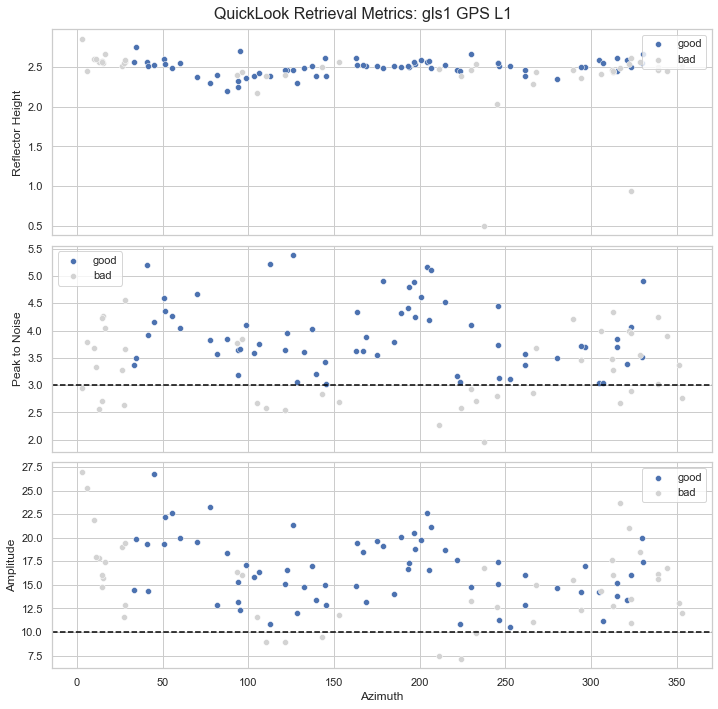

In [13]:
success, fail = quicklook_metrics(args, datakeys)
fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(10,10), sharex=True)
fig.suptitle(f'QuickLook Retrieval Metrics: {args["station"]} GPS L1', size=16)

for i, ax in enumerate(axes):
    g = sns.scatterplot(x='Azimuth',y=success.columns[i+1], data=success, ax=ax, label='good')
    g = sns.scatterplot(x='Azimuth',y=fail.columns[i+1], data=fail, ax=ax, color='lightgrey', label='bad')
    
axes[0].legend(loc='upper right')
avg_rh = np.mean(success['Reflector Height'])
qc_val_peak2noise = round(min(success['Peak to Noise']))
axes[1].axhline(qc_val_peak2noise, linestyle='--', color='black', label='QC value used')
qc_val_amp = round(min(success['Amplitude']))
axes[2].axhline(qc_val_amp, linestyle='--', color='black', label='QC value used')
print(f'Average reflector height value: {avg_rh:.1f}')
print('QC value for peak to noise:', qc_val_peak2noise)
print('QC value for amplitude:', qc_val_amp)

plt.tight_layout()
plt.show()

In the top plot we see that the retrieved reflector heights are consistent at all azimuths.
Retrievals for azimuths between 340 degrees and 40 degrees are consistently marked as not having
met quality control settings.From the center plot we can see that a peak2noise QC metric of 3 is reasonable. 
Similarly, the amplitudes (bottom plot) are generally larger than 10, so 8 is an acceptable minimum value.

The first step is to make SNR files for the year 2012:

In [15]:
args = check_parameters.rinex2snr(station,year,1, doy_end=366, translator='fortran')
rnx.run_rinex2snr(**args)

Will seek RINEX file  gls1  year: 2012  doy: 1  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls10010.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 2  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls10020.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 3  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls10030.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 4  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls10040.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 5  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls10050.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 6  translate with  f



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls10450.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 46  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls10460.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 47  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls10470.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 48  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls10480.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 49  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls10490.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 50  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Project



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls10890.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 90  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls10900.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 91  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls10910.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 92  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls10920.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 93  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls10930.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 94  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Project



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls11330.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 134  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls11340.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 135  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls11350.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 136  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls11360.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 137  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls11370.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 138  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Pr



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls11770.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 178  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls11780.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 179  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls11790.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 180  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls11800.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 181  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls11810.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 182  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Pr



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls12210.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 222  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls12220.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 223  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls12230.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 224  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls12240.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 225  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls12250.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 226  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Pr



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls12650.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 266  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls12660.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 267  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls12670.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 268  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls12680.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 269  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls12690.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 270  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Pr



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls13090.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 310  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls13100.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 311  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls13110.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 312  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls13120.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 313  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls13130.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 314  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Pr



SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls13530.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 354  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls13540.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 355  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls13550.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 356  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls13560.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 357  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls13570.12.snr66
Will seek RINEX file  gls1  year: 2012  doy: 358  translate with  fortran


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Pr

We will next analyze a year of L1 GPS reflection data from this site. We will use the default minimum and maximum 
reflector height values (0.4 and 6 meters). But for the reasons previously stated, we will set a minimum elevation angle 
of 7 degrees. We also specify that we only want to use the L1 data and set peak2noise and a mimimum
amplitude for the periodograms. We use the utility **make_json_input** to set and store these analysis settings:

In [19]:
check_parameters.make_json(station, lat, long, height, e1=7, peak2noise=3, ampl=8, l1=True)

writing out to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/input/gls1.json


In [20]:
# This is the json file that was created
json_file = 'input/gls1.json'
with open(json_file, "r") as myfile:
    file = json.load(myfile)
    file['azval'] = [40,90,90,180,180,270,270,330]
os.remove(json_file)
with open(json_file, 'w') as f:
    json.dump(file, f, indent=4)
    
with open(json_file, "r") as myfile:
    file = json.load(myfile)

file

{'station': 'gls1',
 'lat': 66.4794,
 'lon': -46.3102,
 'ht': 2148.578,
 'minH': 0.5,
 'maxH': 6,
 'e1': 7,
 'e2': 25,
 'NReg': [0.5, 6],
 'PkNoise': 3,
 'polyV': 4,
 'pele': [5, 30],
 'ediff': 2,
 'desiredP': 0.005,
 'azval': [40, 90, 90, 180, 180, 270, 270, 330],
 'freqs': [1],
 'reqAmp': [8],
 'refraction': True,
 'overwriteResults': True,
 'seekRinex': False,
 'wantCompression': False,
 'plt_screen': False,
 'onesat': None,
 'screenstats': True,
 'pltname': 'gls1_lsp.png',
 'delTmax': 75}

We have also excluded a bit of the northern tracks by hand-editing the json. This is not required as 
the software appears to be appropriately removing these unreliable azimuths. Note: the removal of these
azimuths is more related to the GPS satellite inclination than local conditions at gls1.

Now that you have SNR files and json inputs, you can go ahead and estimate reflector heights for the year 2012:

In [21]:
year = 2012
doy = 1
doy_end = 366
plt=False
args = check_parameters.gnssir(station, year, doy, doy_end=doy_end, plt=plt, screenstats=False)
year_list = list(range(year, args['year_end'] + 1))
doy_list = list(range(doy, args['doy_end'] + 1))
for year in year_list:
    args['args']['year'] = year
    for doy in doy_list:
        args['args']['doy'] = doy
        guts.gnssir_guts(**args['args'])

A station specific refraction output file will be written to  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/input/gls1_refr.txt
The large refraction file should be stored here: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/input/gpt_1wA.pickle
station specific refraction file written
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//001.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls10010.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//002.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls10020.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//003.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls10030.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//039.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls10390.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//040.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls10400.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//041.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls10410.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//042.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls10420.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//043.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//078.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls10780.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//079.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls10790.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//080.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls10800.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//081.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls10810.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//082.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//117.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls11170.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//118.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls11180.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//119.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls11190.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//120.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls11200.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//121.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//156.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls11560.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//157.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls11570.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//158.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls11580.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//159.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls11590.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//160.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//195.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls11950.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//196.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls11960.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//197.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls11970.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//198.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls11980.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//199.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//234.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls12340.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//235.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls12350.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//236.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls12360.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//237.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls12370.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//238.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//273.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls12730.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//274.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls12740.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//275.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls12750.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//276.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls12760.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//277.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//312.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls13120.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//313.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls13130.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//314.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls13140.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//315.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls13150.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//316.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//351.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls13510.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//352.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls13520.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//353.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls13530.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//354.txt
reading from this snr file  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/snr/gls1/gls13540.12.snr66
Results are written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2012/results/gls1//355.txt
reading from this snr file  /Users/enloe/UNAVCO_Project

We will use the **daily_avg** tool to compute a daily average RH. A median filter is set to 0.25 meters 
and 30 individual tracks are required in order to recover a daily average:

In [32]:
check_parameters.daily_avg(station, medfilter=.25, ReqTracks=30, plt2screen=False, txtfile='gls1-dailyavg.txt')

all RH will be written to:  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/Files/gls1_allRH.txt
Number of files in  2012 366
not enough retrievals on  2012 6 9 20
Daily average RH png file saved as:  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/Files/gls1_RH.png
Daily average RH will be written to:  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/Files/gls1-dailyavg.txt


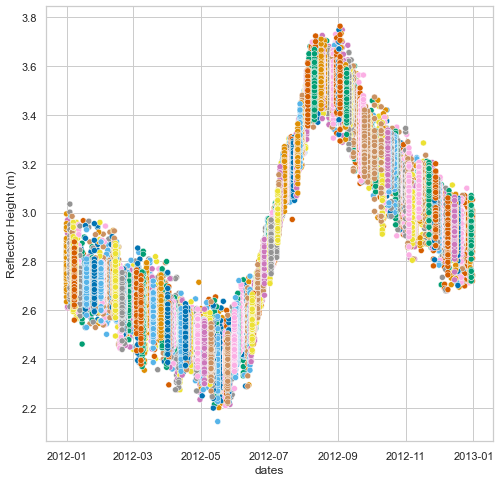

In [85]:
import matplotlib.pyplot as plt
def read_allRH_file(filepath, regex):
    data = {'dates': [], 'rh': []}
    #read daily average reflector heights
    with open(f'{refl_code_dir}{filepath}', 'r') as myfile:
        file = myfile.read()
        matches = re.finditer(regex, file, flags=re.MULTILINE)

        for match in matches:
            ydoy = f'{int(match.group("year"))}-{int(match.group("doy"))}'
            date = datetime.strptime(ydoy, '%Y-%j').date()
            data['dates'].append(date)
            data['rh'].append(float(match.group('rh')))
            
    return data

regex = '^ (?P<year>[ \d]+) +(?P<doy>[\d]+) +(?P<rh>[\d|-|.]+)'
filepath = f'/Files/{station}_allRH.txt'
data = read_allRH_file(filepath, regex)

df = pd.DataFrame(data, index=None, columns=['dates', 'rh'])
plt.figure(figsize=(8,8))
g = sns.scatterplot(x='dates', y='rh', data=df, hue='dates', palette='colorblind', legend=False)
g.set_ylabel('Reflector Height (m)');

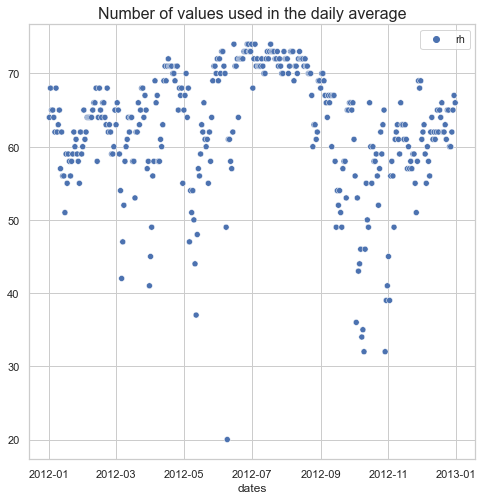

In [97]:
plt.figure(figsize=(8,8))
df_group = df.groupby(['dates']).agg(['count'])
g = sns.scatterplot(data=df_group)
g.set_title('Number of values used in the daily average', size=16);

In [38]:
regex = '^ (?P<year>[ \d]+) +(?P<doy>[\d]+) +(?P<rh>[\d|-|.]+)'
filepath = f'/Files/{station}-dailyavg.txt'
data = read_allRH_file(filepath, regex)
df = pd.DataFrame(data, index=None, columns=['dates', 'rh'])

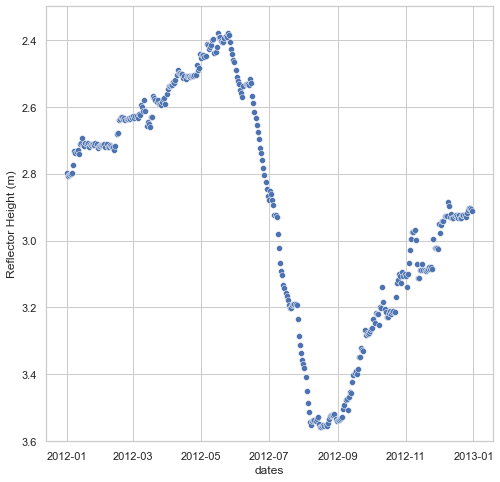

In [37]:
plt.figure(figsize=(8,8))
g = sns.scatterplot(x='dates', y='rh', data=df, legend=False)
g.set_ylim(3.6,2.3)
g.set_ylabel('Reflector Height (m)');

Three plots are returned. The first is all tracks. The second shows the number of tracks used in the daily average.Finally, the average RH each day for the year 2012.

This data shown in the last plot show you long-term accumulation as well as relatively small snow accumulation events. The overall 
plot is dominated by the large melt event in the summer.

**Things to think about:**

* Why do the number of useable tracks drop drastically at various times in the year?

* Why are the number of tracks retrieved in the summer days consistently higher in number than 
in other times of the year? What is different about the surface in the summer of 2012?

* How would you find out whether this year was anomalously large melt?  

* Try comparing the GNSS-IR results with the [validation data](https://tc.copernicus.org/articles/14/1985/2020/tc-14-1985-2020.pdf)

The original [J. Glaciology paper](https://www.kristinelarson.net/wp-content/uploads/2015/10/LarsonWahrKuipers_2015.pdf ) discussing this site.